# Modeling Hot Water Energy

### Attach current folder to project directory
### Ensure Seed for reproducability
### Set GPU configurations

In [1]:
seed_value = 123

import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Select the period at which we perform experiments

In [21]:
period = 6  # the period to sample the data at. 1 period= 5 minutes

### Read the cleaned data

In [4]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


### Sum half hour energy data

In [7]:
# return a new column which is the sum of previous window_size values
def windowsum(df, window_size: int, column_name: str):
    return df[[column_name]].rolling(window=window_size, min_periods=window_size).sum()

df['30min_hwe'] = windowsum(df,window_size=period, column_name='hwe')
df = dp.dropNaNrows(df)

df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,31.090181,72.197220,85.0,10.762690,1.567676,555.0,72.438095,0.002307,9.412869,114.48685,93.302300,69.271747
2018-11-16 10:35:00,31.090181,72.197220,85.0,10.564563,19.244667,561.0,72.438095,0.002314,9.568605,117.11233,96.343720,67.570122
2018-11-16 10:45:00,31.090181,72.197220,85.0,10.697302,23.290321,573.0,72.400000,0.006438,8.650812,113.07264,94.614395,66.565878
2018-11-16 10:50:00,31.090181,71.896065,85.0,11.076882,16.465296,579.0,72.400000,0.007606,8.232664,114.02831,95.410160,66.064175
2018-11-16 10:55:00,31.090181,71.596306,89.0,11.479505,5.206500,589.0,72.438095,0.010025,8.469596,115.26057,96.472720,65.850071


### Smooth the data 

In [8]:
# Smoothing the data
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

df_smoothed = dp.dfsmoothing(df=df,
                             column_names=list(df.columns),
                             order=order,
                             Wn=cutoff,
                             T=T)

### Sample data at half hour

In [11]:
# Sample the data at half hour intervals
df_smoothed = dp.sample_timeseries_df(df_smoothed, period=period)
df_smoothed.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,30min_hwe
2018-11-16 10:30:00,30.993272,72.150486,84.717147,10.259725,1.567559,560.337060,72.428025,-0.019260,9.423610,114.563037,92.970058,67.252497
2018-11-16 11:00:00,30.889967,71.491976,86.906144,10.717770,1.628633,595.256072,72.429389,-0.077976,8.985507,112.734029,92.385405,65.518758
2018-11-16 11:30:00,31.029884,71.140593,88.827702,11.719749,1.369406,610.780989,72.443166,-0.092517,7.725145,110.744792,91.701689,67.373714
2018-11-16 12:00:00,32.014107,71.464986,90.182589,13.376567,0.665984,583.547763,72.468773,0.017836,4.889709,108.046403,91.075094,75.193039
2018-11-16 12:30:00,34.152125,72.431938,89.892601,14.394451,-0.000064,505.321631,72.478809,0.216811,1.718718,105.323471,91.328901,83.948465


### Create 7 day chunks of data

In [12]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist_alt(df_smoothed[['oat', 'orh', 'sat', 'ghi', 'hw_sf', '30min_hwe', 'hw_st']],
                      subsequence=True,
                      period=period,
                      days=7,
                      hours=0)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 61


In [ ]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:  # [:40]:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1,
        split=0.85
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

### Custom way to create Training Data; Choose inputs, outputs, lags, train-test splits etc

In [ ]:
data_weeks = 12 # Create a large initial block 3 months ~ 12 weeks of training and testing data
splitvalue =  11/12  # One week for training
weeklist = []  # create list of training, testing arrays
inputcols = ['oat','orh', 'sat', 'ghi', 'hw_sf', 'hw_st']  # input data
outputcols = ['30min_hwe']  # output data
lag = -1  # predict next time step energy

from pandas import concat
def quickmerge(listdf):
    return concat(listdf)

### Initial Data Block for offline training

In [ ]:
datablock = dflist[:data_weeks]
datablock_df = quickmerge(datablock)

X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue
    )
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[0].year), 
                                      str(datablock_df.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

### Create small blocks of data for weekly training

In [ ]:
for weekdata in dflist[data_weeks:]:
    
    datablock = datablock[1:]+[weekdata]# remove 1st of data from initial_datablock
    datablock_df = quickmerge(datablock)
    # and add new week data from weekdata
    
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        datablock_df,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=lag,
        split=splitvalue
    )
    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_df.index[-1].year), 
                                      str(datablock_df.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

print('Length of weeklist: {}'.format(len(weeklist)))

### Print size and shape of data to feed to the LSTM for sanity checks

In [ ]:
for week in weeklist:
    for key,value in week.items():
        print("name: {}, value: {}".format(key, value.shape if not isinstance(value,str) else value))

### Create Folder to save models and tensorboard logs

In [15]:
path = '../results/lstm_hwe_trial1/'
!rm -rf ../results/lstm_hwe_trial1

# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Clear the Tensorflow graph from previous training

In [17]:
try:
    del model
except NameError:
    pass

K.clear_session()

### Configure the LSTM model architecture

In [ ]:
modelconfig = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 4,
    'train_epochs':3000,
    'retrain_from_layers':2
}

### Start the week by week training procedure

In [ ]:
modeldesigndone = False
initial_epoch = 0
freeze_model = True
reinitialize = True

for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        
        try:
            del model
        except NameError:
            pass

        K.clear_session()
        
        #Instantiate learner model
        nn_model = mp.lstm_model_transferlearning(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=period)

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                           densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])
        
        # compile model
        nn_model.model_compile()

        # creating early stopping and learning reate changing callbacks
        nn_model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = nn_model.train_model(X_train, y_train, X_test, y_test, epochs=modelconfig['train_epochs'],
                                initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = nn_model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Idx=weekdata['Id'],
                                                     outputdim_names=['Hot Water Energy'])
    
    # freeze all but dense layers at the top and compile with new weights
    if freeze_model:
        for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
            layer.trainable = False
        freeze_model = False
            
    if reinitialize:  
        for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
            layer.kernel.initializer.run(session=K.get_session())
            layer.bias.initializer.run(session=K.get_session())
    
    # compile model
    nn_model.model_compile()
    
    # creating early stopping and learning reate changing callbacks
    # nn_model.model_callbacks()

### Plot the week by week CVRMSE error

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/lstm_hwe_trial1/30min Results_File.txt


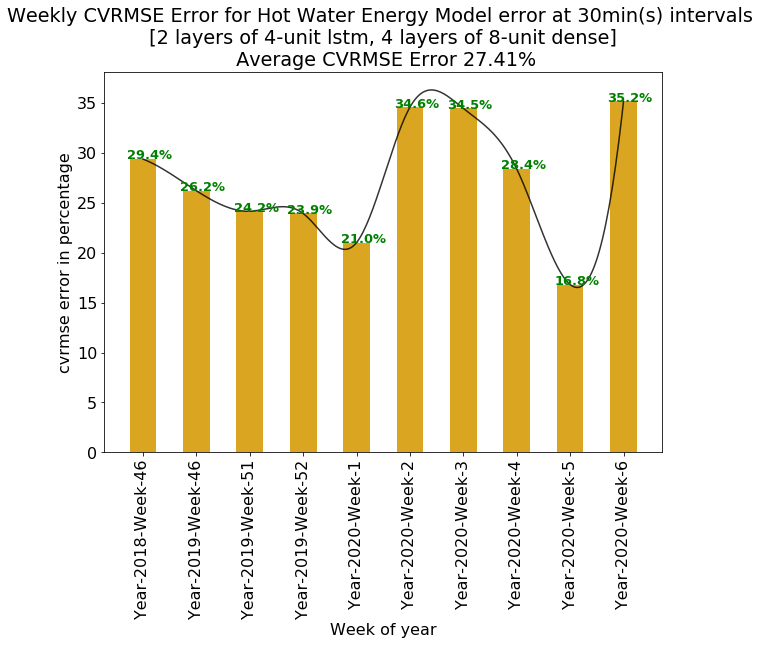

In [20]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 2 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Code cemetery

In [ ]:
# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)

In [ ]:
#model.model.summary()

#nn_model.model.layers[-1].input_shape

#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())

#nn_model.model.layers[-1].output_shape